In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
import torchmetrics
from torchvision import transforms
import torchvision
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, image_normalize=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'Image')
        self.mask_folder = os.path.join(root_dir, 'Mask')
        self.image_list = os.listdir(self.image_folder)
        self.transform = transform
        self.image_normalize = image_normalize

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_list[idx])
        mask_name = os.path.join(self.mask_folder, self.image_list[idx].replace(".jpg",".png"))  # Assuming same names for images and masks

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')  # Convert to grayscale if masks are single-channel

        if self.transform:
            # Use the same random seed for both transformations so that same transformation is applied to both
            seed = np.random.randint(2147483647)

            np.random.seed(seed)
            torch.manual_seed(seed)
            image = self.transform(image)
            
            # Reset the seed for the mask transformation
            np.random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        if self.image_normalize:
            image = self.image_normalize(image)

        return image, mask

# Define normalization for images separately
image_normalize = transforms.Normalize(mean=[0.49846329, 0.49645642, 0.45085248], std=[0.24551028, 0.2225388,  0.23975675]) # fill with real valuess
# image_normalize = None

# root_directory = r"/kaggle/input/flood-area-segmentation"
root_directory = r"D:\Datasets\flood_area_segmentation"
my_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(256) ,
    # transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
])

custom_dataset = CustomDataset(root_directory, transform=my_transform, image_normalize=image_normalize)

# Split the dataset 20-80%
train_dataset, test_dataset = random_split(custom_dataset, [0.2, 0.8])

# Use DataLoaders for both training and test sets
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


In [9]:
import torch

def denormalize(tensor, mean, std):
    """
    Denormalize a tensor of images.

    Args:
    tensor (torch.Tensor): Tensor of shape (B, C, H, W) to denormalize.
    mean (tuple): Mean values for each channel.
    std (tuple): Standard deviation values for each channel.

    Returns:
    torch.Tensor: Denormalized tensor.
    """
    # Convert mean and std to tensors if they are not already
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std)
    
    # Broadcast mean and std to match tensor shape
    mean = mean[:, None, None]
    std = std[:, None, None]

    # Denormalize
    denorm_tensor = tensor * std + mean

    return denorm_tensor


In [10]:
# IMPORANT!!!!!!!!!!!!!!!! These functions return data and do not do it inplace, make sure to assign the return values to a variable


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
# move data to CPU
train_data_loader = DeviceDataLoader(train_data_loader, torch.device('cpu'))
test_data_loader = DeviceDataLoader(test_data_loader, torch.device('cpu'))

torch.Size([32, 3, 256, 256])
torch.Size([32, 1, 256, 256])


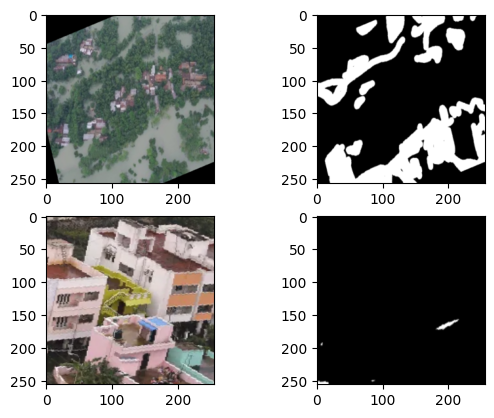

In [12]:
# lets see if we can apply our transforms
for img, mask in train_data_loader:
    
    img = denormalize(img, mean=[0.49846329, 0.49645642, 0.45085248], std=[0.24551028, 0.2225388,  0.23975675])

    print(img.shape)
    print(mask.shape)

    to_device(img, torch.device('cpu'))
    to_device(mask, torch.device('cpu'))
    to_device(img, torch.device('cpu'))

    plt.subplot(2, 2, 1)
    plt.imshow(img[0].permute(1, 2, 0))
    plt.subplot(2, 2, 2)
    plt.imshow(mask[0].permute(1, 2, 0), cmap='gray')

    plt.subplot(2, 2, 3)
    plt.imshow(img[1].permute(1, 2, 0))
    plt.subplot(2, 2, 4)
    plt.imshow(mask[1].permute(1, 2, 0), cmap='gray')

    break

In [13]:
res_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
# print(list(res_model.children()))

In [14]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, padding=0):
        super(ConvolutionBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, dilation=dilation, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
                      )
    
    def forward(self, x):
        return self.block(x)

In [15]:
class ASPP(nn.Module):
    def __init__(self, input_channels, output_channels):
        # output channels is num of output channels per atrous layer
        super(ASPP, self).__init__()
        
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.conv_1x1 = ConvolutionBlock(in_channels=input_channels, out_channels=output_channels, kernel_size=1)

        self.conv_1x1_d1 = ConvolutionBlock(in_channels=input_channels, out_channels=output_channels, kernel_size=1, dilation=1)
        self.conv_3x3_d6 = ConvolutionBlock(in_channels=input_channels, out_channels=output_channels, kernel_size=3, dilation=6, padding=6) # according to formula (https://discuss.pytorch.org/t/converting-tensorflow-model-to-pytorch-issue-with-padding/84224) the padding (p) should be = dialation rate (d) for the input and output image to be of same H & W 
        self.conv_3x3_d12 = ConvolutionBlock(in_channels=input_channels, out_channels=output_channels, kernel_size=3, dilation=12, padding=12) 
        self.conv_3x3_d18 = ConvolutionBlock(in_channels=input_channels, out_channels=output_channels, kernel_size=3, dilation=18, padding=18) 

        self.final_conv = ConvolutionBlock(in_channels=output_channels*5, out_channels=output_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out_1 = self.conv_1x1_d1(x)
        out_6 = self.conv_3x3_d6(x)
        out_12 = self.conv_3x3_d12(x)
        out_18 = self.conv_3x3_d18(x)

        out_pool = self.avg_pool(x)
        out_pool = self.conv_1x1(out_pool)
        out_pool = nn.functional.interpolate(out_pool, size=(x.shape[-2],x.shape[-1]), mode="bilinear")

        concatenated = torch.cat([out_pool, out_1, out_6, out_12, out_18], dim=1)
        out = self.final_conv(concatenated)

        return out
        

        

In [16]:

class DeeplabV3Plus(nn.Module):
    def __init__(self):
        super(DeeplabV3Plus, self).__init__()
        resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
        self.base_resnet = nn.Sequential(*list(resnet.children())[-5:-3])
        # to avoid doing double work we will feed the output of lower_layer_resnet (from starting to 6th last layer (5th is excluded))
        # to the above resnets 5th last layer to 4th last layer (-3 is excluded caz python) 

        # output channels is num of output channels per atrous layer
        # input channels = num of output channels by the base model (self.base_resnet)
        self.aspp = ASPP(1024, 256) # num of output channels = 1280 (256 x 5)

        self.conv_1x1_enc = ConvolutionBlock(in_channels=256, out_channels=48, kernel_size=1)

        self.lower_layer_resnet = nn.Sequential(*list(resnet.children())[:-5])
        self.conv_1x1_low_layer_res = ConvolutionBlock(in_channels=256, out_channels=48, kernel_size=1)

        self.conv_3x3 = ConvolutionBlock(in_channels=48+48,out_channels=1,kernel_size=3,padding=1) # out_channels = num of classes/objects we want to segment

    def forward(self, x):
       
        
        lower_layer_resnet_out = self.lower_layer_resnet(x) # this output has to be used in decoder block (this has layers from start to -6)
        
        # to avoid doing double work we will feed the output of lower_layer_resnet (from starting to 4th last layer (5th is excluded))
        # to the above resnets 5th last layer to 4th last layer (-3 is excluded caz python) 

        base_out = self.base_resnet(lower_layer_resnet_out) # this resnet has layers from -5 to -4

        enc_out = self.aspp(base_out)
        enc_out = self.conv_1x1_enc(enc_out)
        upscaled_enc_out = nn.functional.interpolate(enc_out, scale_factor=4, mode="bilinear")

        lower_layer_resnet_out = self.conv_1x1_low_layer_res(lower_layer_resnet_out)

        out = torch.concat([lower_layer_resnet_out, upscaled_enc_out], dim=1)
        
        out = self.conv_3x3(out)
        out = nn.functional.interpolate(out, scale_factor=4, mode="bilinear")
        
        return out

        

In [17]:
model = DeeplabV3Plus()
model = to_device(model, torch.device('cpu'))
for imgs,masks in train_data_loader:
    x = model(imgs)
    break


In [18]:
import torch.nn.functional as F

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    SMOOTH = 1e-6
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W

    
    intersection = (outputs.int() & labels.int()).float().sum()  # Will be zero if Truth=0 or Prediction=0
    union = (outputs.int() | labels.int()).float().sum()         # Will be zzero if both are 0
    

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return iou  

import torch

def iou_loss(predicted_masks, target_masks):
    """
    Calculate IoU loss (1 - IoU) between predicted masks and target masks.

    Args:
    predicted_masks (torch.Tensor): Predicted mask tensor with shape [B, 1, H, W].
    target_masks (torch.Tensor): Target mask tensor with shape [B, 1, H, W].

    Returns:
    torch.Tensor: IoU loss.
    """
    # Flatten the predicted and target masks
    predicted_masks_flat = predicted_masks.view(predicted_masks.size(0), -1)
    target_masks_flat = target_masks.view(target_masks.size(0), -1)

    # Compute intersection and union
    intersection = torch.sum(predicted_masks_flat * target_masks_flat, dim=1)
    union = torch.sum(predicted_masks_flat + target_masks_flat, dim=1) - intersection

    # Calculate IoU
    iou = intersection / union.float().clamp(min=1e-8)

    # Compute IoU loss (1 - IoU)
    iou_loss = 1 - iou.mean()

    return iou_loss



def validation(model, trainLoader, loss_func=F.binary_cross_entropy_with_logits):
        jaccard = torchmetrics.JaccardIndex(task='multiclass', num_classes=2)

        with torch.no_grad(): # IMPORTANT!!!!!! Remeber to put with torch.no_grad() when testing the model or the gradients will keep accumulating and the memory will run out
            losses_sum = 0
            mIoU_sum = 0
            counter = 0
            model.eval()
            for imgs, masks in trainLoader:
                predictions = model(imgs)
                masks = torch.unsqueeze(masks, 1) # get the labels to shape [4,1]
                # also change dtype of labels frm int64 to float32
                masks = masks.type(torch.float32)
                # masks have shape = [32, 1, 1, 256, 256] while predictions have shape = [32, 1, 256, 256] so squeeze masks
                masks = torch.squeeze(masks, 1)

                loss  = loss_func(predictions, masks)
                losses_sum += loss

                IoU = iou_pytorch(predictions, masks)
                mIoU_sum += IoU
                

                counter += 1

                avg_iou = mIoU_sum/counter
                avg_loss = losses_sum/counter

                

        return avg_iou,avg_loss



def train_step(model, input_batch, actual_outputs, loss_func=iou_loss):
        pred = model(input_batch)
        loss = loss_func(pred, actual_outputs) + iou_loss(pred, actual_outputs)
        return loss

def fit_model(model, lr, trainLoader, epochs, opt=torch.optim.Adam, loss_func = F.binary_cross_entropy_with_logits, grad_clip_value=None):

    optimizer = opt(model.parameters(), lr,)
    model.train()

    lr_schduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.33,patience=3,verbose=True)


    for epoch in range(epochs):

        epoch_losses = []

        for imgs, masks in trainLoader:
            masks = torch.unsqueeze(masks, 1) 
            # also change dtype of masks frm int64 to float32
            masks = masks.type(torch.float32)
            # masks have shape = [32, 1, 1, 256, 256] while predictions have shape = [32, 1, 256, 256] so squeeze masks
            masks = torch.squeeze(masks, 1)
            

            loss = train_step(model, imgs, masks, loss_func)
            loss.backward()

            if grad_clip_value!=None:
                nn.utils.clip_grad.clip_grad_value_(model.parameters(), grad_clip_value)


            optimizer.step()
            optimizer.zero_grad()

            epoch_losses.append(loss.item())

        avg_loss = sum(epoch_losses)/len(epoch_losses)
        print(f"Avg loss for epoch {epoch} = {avg_loss}")
        lr_schduler.step(avg_loss)


    acc,loss = validation(model, trainLoader, loss_func)
    print(f"Done! mIoU on training set: {acc} & Loss: {loss}")


In [19]:
device = get_default_device()

model = to_device(model, device)

trainLoader = DeviceDataLoader(train_data_loader, device)
testLoader = DeviceDataLoader(test_data_loader, device)

In [20]:
print("Initial iou:")
iou,loss = validation(model, testLoader)
print(iou)

Initial iou:
tensor(1.7542e-12)


In [24]:
fit_model(model, 0.001, trainLoader, 1, grad_clip_value = 0.1)


Avg loss for epoch 0 = 0.9696004092693329


KeyboardInterrupt: 

In [22]:
print("iou:")
iou,loss = validation(model, testLoader)
print(iou)

iou:


KeyboardInterrupt: 

In [ ]:
# lets see if we can apply our transforms
with torch.no_grad():
    
    for img, mask in testLoader:
        
        pred = F.sigmoid(model(img))
        
        img = to_device(img, torch.device('cpu'))
        mask = to_device(mask, torch.device('cpu'))
        pred = to_device(pred, torch.device('cpu'))
        
        
        threshold = 0.5
        pred = (pred > threshold).float()
        pred.detach().numpy()
        
        img = denormalize(img, mean=[0.49846329, 0.49645642, 0.45085248], std=[0.24551028, 0.2225388,  0.23975675])
        

        plt.subplot(2, 3, 1)
        plt.imshow(img[0].permute(1, 2, 0))
        plt.subplot(2, 3, 2)
        plt.imshow(mask[0].permute(1, 2, 0), cmap='gray')
        plt.subplot(2, 3, 3)
        plt.imshow(pred[0].permute(1, 2, 0), cmap='gray')

        plt.subplot(2, 3, 4)
        plt.imshow(img[1].permute(1, 2, 0))
        plt.subplot(2, 3, 5)
        plt.imshow(mask[1].permute(1, 2, 0), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(pred[1].permute(1, 2, 0), cmap='gray')

        break

NameError: name 'torch' is not defined